In [160]:
import pandas as pd
import seaborn as sns
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
import os
import sys
from ocp_table_tpot.globals import Globals as gd
from tpot import TPOTRegressor
sys.path.insert(0,'..')

from sklearn.pipeline import make_pipeline, make_union
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PolynomialFeatures,QuantileTransformer,Normalizer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.metrics import mean_squared_error,make_scorer
from copy import copy
from tpot.builtins import StackingEstimator
import pickle

from src.models.model import mase,TimeSeriesSplitImproved
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC,RANSACRegressor,Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from skgarden.quantile import RandomForestQuantileRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
import umap

N= 150
feature_subset_rougher_df = pd.read_csv(f'./shap-importance-rougher-diff_deriv_normalized_with_interaction.csv').head(N)
feature_subset_final_df = pd.read_csv(f'./shap-importance-final-diff_deriv_normalized_with_interaction.csv').head(N)


data_dict = pd.read_pickle(f'../data/processed/data_dict_all.pkl')
tgt = ['final.output.recovery','rougher.output.recovery']
year = 2019
X = data_dict[year][f'X_train_tsclean']
print(X.shape)
y = data_dict[year]['y_train']
X_test = data_dict[year]['X_test_ts']
mask = data_dict[year]['mask']
exclude_pts = data_dict[year]['excl'].set_index('date').tz_localize('UTC')
#mask_na_two_row=y[y[tgt].isna()].index.union(y[y[tgt].isna()].index + pd.Timedelta('1 hour')).union(y[y[tgt].isna()].index + pd.Timedelta('2 hour'))
inds = mask.index.difference(exclude_pts.index)

X=X.loc[inds,:]
y=y.loc[inds,:]
mask=mask[inds]
print(X.shape)
print(X_test.shape)

print(f'1) X shape: {X.shape},y: {y.shape}')
X = X[mask]
y = y[mask][tgt]
print(f'2) Train shape: {X.shape}')
X_filt = X.filter(regex  ="rougher|hour|dayw",axis = 1)
train_df = pd.concat([X,y],axis= 1)
train_df.head()


(16859, 1207)
(16063, 1207)
(5856, 1207)
1) X shape: (16063, 1207),y: (16063, 7)
2) Train shape: (12838, 1207)


,primary_cleaner.input.copper_sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,value__minimum_p6_rougher.input.floatbank11_xanthate_rat_value__quantile__q_0.95_p24_rougher.input.feed_fe,value__minimum_p6_rougher.input.floatbank11_xanthate_rat_encod_val_primary_cleaner.input.copper_sulfate,secondary_cleaner.state.floatbank2_a_air_rat_encod_dif_rougher.input.feed_pb,secondary_cleaner.state.floatbank2_a_air_rat_value__quantile__q_0.95_p24_rougher.input.feed_fe,secondary_cleaner.state.floatbank2_a_air_rat_encod_val_primary_cleaner.input.copper_sulfate,encod_dif_rougher.input.feed_pb_rat_value__quantile__q_0.95_p24_rougher.input.feed_fe,encod_dif_rougher.input.feed_pb_rat_encod_val_primary_cleaner.input.copper_sulfate,value__quantile__q_0.95_p24_rougher.input.feed_fe_rat_encod_val_primary_cleaner.input.copper_sulfate,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 01:00:00+00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,-499.315107,...,0.968621,0.039995,-37.850820,4.174026,0.172350,-0.126404,-0.005219,0.040625,69.266198,86.843261
2016-01-15 02:00:00+00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,-500.870069,...,0.959691,0.040878,-35.034606,4.155469,0.177002,-0.134590,-0.005733,0.041914,68.116445,86.842308
2016-01-15 03:00:00+00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,-500.727997,...,0.959910,0.040149,-29.618820,4.146391,0.173427,-0.155975,-0.006524,0.041157,68.347543,87.226430
2016-01-15 04:00:00+00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,-500.888152,...,0.960253,0.040726,-29.106736,4.161027,0.176478,-0.158946,-0.006741,0.041734,66.927016,86.688794
2016-01-15 05:00:00+00:00,115.581252,12.470773,7.25,0.965760,1602.964922,-498.090944,1602.074298,-500.179481,1602.154812,-498.642614,...,0.960596,0.040533,-33.143443,4.160922,0.175571,-0.141537,-0.005972,0.041520,69.465816,88.156912


## Prepare folding scheme (do i need it ?) and load the pre-trained metafeatures

In [216]:
# Get the K fold indexes
n_folds =6
kf = KFold(n_splits=n_folds, shuffle=False, random_state=156)

with open("../models/test_features_rougher.pkl", "rb") as f:
    test_rougher = pickle.load(f)
with open("../models/train_features_rougher.pkl", "rb") as f:
    train_rougher = pickle.load(f)
with open("../models/test_features_final.pkl", "rb") as f:
    test_final = pickle.load(f)
with open("../models/train_features_final.pkl", "rb") as f:
    train_final = pickle.load(f)
    
## For linear models:
with open("../models/test_features_rougher_linear.pkl", "rb") as f:
    test_rougher_lm = pickle.load(f)
with open("../models/train_features_rougher_linear.pkl", "rb") as f:
    train_rougher_lm = pickle.load(f)
with open("../models/test_features_final_linear.pkl", "rb") as f:
    test_final_lm = pickle.load(f)
with open("../models/train_features_final_linear.pkl", "rb") as f:
    train_final_lm = pickle.load(f)


    
    

## Define the N features for which to pull the level0 features for; separately for rougher & final

In [246]:
N_final = [50,150,250,350,450,550]
N_rougher = [50,150,250,350]
   
# Retrieve rougher predictions:
level0_rougher_train = np.hstack([train_rougher[Nr] for Nr in N_rougher])
level0_final_train = np.hstack([train_final[Nf] for Nf in N_final])

level0_rougher_test = np.hstack([test_rougher[Nr] for Nr in N_rougher])
level0_final_test = np.hstack([test_final[Nf] for Nf in N_final])
tgt = 'rougher.output.recovery'
predictions = level0_rougher_train
yTrue = y[tgt].values
print(f'ROUGHER Shape y : {yTrue.shape}, preds : {level0_rougher_train.shape}' )
print(f'FINAL Shape y : {yTrue.shape}, preds : {level0_final_train.shape}' )

r= mase(level0_rougher_train.mean(axis = 1),y['rougher.output.recovery'].values)
f=mase(level0_final_train.mean(axis = 1),y['final.output.recovery'].values)
print(f'R {r} F {f} sum = {r*0.25+0.75*f}')
print(r)

ROUGHER Shape y : (12838,), preds : (12838, 24)
FINAL Shape y : (12838,), preds : (12838, 36)
R 2.267143620278212 F 1.4497423618837426 sum = 1.6540926764823598
2.267143620278212


In [210]:
# for Linear
N_final_lm = [50,150,250,350]
N_rougher_lm = [50,150]
# Retrieve rougher predictions:
level0_rougher_train_lm = np.hstack([train_rougher_lm[Nr] for Nr in N_rougher_lm])
level0_final_train_lm = np.hstack([train_final_lm[Nf] for Nf in N_final_lm])

level0_rougher_test_lm = np.hstack([test_rougher_lm[Nr] for Nr in N_rougher_lm])
level0_final_test_lm = np.hstack([test_final_lm[Nf] for Nf in N_final_lm])
tgt = 'rougher.output.recovery'
predictions_lm = level0_rougher_train_lm
yTrue = y[tgt].values
print(f'ROUGHER Shape y : {yTrue.shape}, preds : {level0_rougher_train_lm.shape}' )
print(f'FINAL Shape y : {yTrue.shape}, preds : {level0_final_train_lm.shape}' )

r= mase(level0_rougher_train_lm.mean(axis = 1),y['rougher.output.recovery'].values)
f=mase(level0_final_train_lm.mean(axis = 1),y['final.output.recovery'].values)
print(f'R {r} F {f} sum = {r*0.25+0.75*f}')
print(r)

ROUGHER Shape y : (12838,), preds : (12838, 8)
FINAL Shape y : (12838,), preds : (12838, 16)
R 2.495285570885101 F 1.644499705403939 sum = 1.8571961717742294
2.495285570885101


In [99]:
#predictions.mean(axis = 1)*r+

## Run an optimization with constraints on positive weights

In [247]:
from scipy.optimize import minimize
predictions_r = level0_rougher_train
ytrue =y['rougher.output.recovery'].values
def f(weights):
    valid_preds_r = np.average(predictions_r, axis=1, weights=weights).reshape((-1,1))
    
    return np.hstack([valid_preds_r])

def loss_function(weights,C = 0.1):
    y_valid_pred = f(weights)
    sc = mase(y_valid_pred[:,0],ytrue) + C*(weights**2).sum()
    #print('loss', sc, 'current weights', weights)
    return sc

opt_weights = minimize(loss_function,
                                [1/predictions_r.shape[1]] * predictions_r.shape[1],
                                constraints=({'type': 'eq','fun': lambda w: 1-sum(w)}),
                                method= 'SLSQP',
                                bounds=[(0.0, 1.0)] * predictions_r.shape[1],
                                options = {'ftol':1e-10},
                            )['x']

print('Optimum weights = ', opt_weights, 'with loss', loss_function(opt_weights))

def acc_function(weights):
    y_valid_pred = f(weights)
    sc = mase(y_valid_pred[:,0],ytrue) 
    return sc

print('Ensembled Accuracy =', acc_function(opt_weights))
w_rougher = opt_weights

predictions_r = level0_final_train
ytrue =y['final.output.recovery'].values


opt_weights = minimize(loss_function,
                                [1/predictions_r.shape[1]] * predictions_r.shape[1],
                                constraints=({'type': 'eq','fun': lambda w: 1-sum(w)}),
                                method= 'SLSQP',
                                bounds=[(0.0, 1.0)] * predictions_r.shape[1],
                                options = {'ftol':1e-10},
                            )['x']

print('Optimum weights = ', opt_weights, 'with loss', loss_function(opt_weights))

def acc_function(weights):
    y_valid_pred = f(weights)
    sc = mase(y_valid_pred[:,0],ytrue) 
    return sc

print('Ensembled Accuracy =', acc_function(opt_weights))

w_final = opt_weights




# 0.00000000e+00 1.53911667e-15 4.63643997e-02 0.00000000e+00
# 7.57377707e-02 8.77897830e-01]

# rougher = [0.06394941 0.04131424 0.03608431 0.04175253 0.04084764 0.04474683 0.18637792 0.07544563 0.07143145 0.07306282 0.16714796 0.15783926]
# final =  [0.03389247 0.0309956  0.05860959 0.0303532  0.03120939 0.034088 0.04629192 0.04832187 0.03993592 0.05727612 0.03868644 0.04596449 0.05082181 0.04129324 0.0481723  0.04222097 0.05384205 0.03739259  0.03535463 0.02802449 0.043193   0.04099059 0.04402116 0.03904817]

Optimum weights =  [0.00000000e+00 6.44075421e-18 1.03268310e-17 0.00000000e+00
 2.23653861e-18 1.15190517e-19 4.16848167e-01 4.84010795e-18
 1.90609799e-18 2.63950085e-18 2.83321637e-01 2.22749255e-01
 4.16187127e-18 0.00000000e+00 0.00000000e+00 6.97044720e-18
 7.81806416e-18 2.93382516e-18 2.56619270e-02 0.00000000e+00
 8.34819952e-18 5.14190138e-02 7.46900518e-18 0.00000000e+00] with loss 2.1796228713168126
Ensembled Accuracy = 2.1489275488662556
Optimum weights =  [9.42941479e-03 0.00000000e+00 1.50658205e-01 8.81637135e-18
 0.00000000e+00 9.97711008e-03 5.89382091e-02 6.93663484e-02
 1.06158013e-02 1.24961729e-01 8.70993660e-03 6.01266062e-02
 8.93892706e-02 3.06858637e-02 7.33098515e-02 3.75680463e-02
 1.09925796e-01 8.08000770e-03 8.97791775e-19 7.20183739e-19
 4.39537592e-02 3.00838465e-02 5.23831992e-02 1.93862803e-02
 1.43131155e-17 6.25603886e-19 1.42998302e-18 1.34714479e-17
 0.00000000e+00 2.45071895e-03 6.92936363e-18 1.22258360e-17
 3.03199255e-18 9.85233419e-18 5.73908

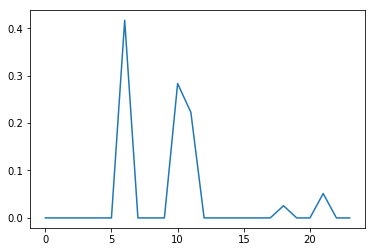

In [249]:
plt.plot(w_rougher)

# Train a random forest on top of individual predictions

In [176]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from skgarden import RandomForestQuantileRegressor



nt = 100
rf_quantile = RandomForestQuantileRegressor(n_estimators=nt,max_depth = 2,min_samples_split = 10)
rf = RandomForestRegressor(n_estimators=nt,max_depth = 2,min_samples_split = 10)

rf_quantile_final =  RandomForestQuantileRegressor(n_estimators=nt,max_depth = 2,min_samples_split = 10)
rf_final =RandomForestRegressor(n_estimators=nt,max_depth = 2,min_samples_split = 10)

X_train_r = np.hstack([level0_rougher_train,level0_rougher_train_lm,X_filt[feature_subset_rougher_df['feature']]])
y_train_r = y['rougher.output.recovery'].values


X_train_f = np.hstack([level0_final_train,level0_rougher_train_lm,X[feature_subset_final_df['feature']]])
y_train_f = y['final.output.recovery'].values

sc_normal = cross_val_predict(rf,X_train_r,y_train_r,cv = kf,n_jobs = 6)
sc_quantile = cross_val_predict(rf_quantile,X_train_r,y_train_r,cv = kf,n_jobs = 6)

sc_normal = mase(sc_normal,y_train_r)
sc_quantile = mase(sc_quantile,y_train_r)

print(f'Scores: normal : {sc_normal} , quantile: {sc_quantile}')
rf_quantile.fit(X_train_r,y_train_r)
rf.fit(X_train_r,y_train_r)

rf_quantile_final.fit(X_train_f,y_train_f)
rf_final.fit(X_train_f,y_train_f)



pred_qrf_final = rf_quantile_final.predict(np.hstack([level0_final_test,level0_final_test_lm,X_test[feature_subset_final_df['feature']]]))
pred_rf_final  =rf_final.predict(np.hstack([level0_final_test,level0_final_test_lm,X_test[feature_subset_final_df['feature']]]))

pred_qrf_rougher = rf_quantile.predict(np.hstack([level0_rougher_test,level0_rougher_test_lm,X_test[feature_subset_rougher_df['feature']]]))
pred_rf_rougher  =rf.predict(np.hstack([level0_rougher_test,level0_rougher_test_lm,X_test[feature_subset_rougher_df['feature']]]))


Scores: normal : 2.3637073637325736 , quantile: 2.3663198099860514


## Make a submission:

In [179]:
preds = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level0_rougher_test.mean(axis=1), 'final.output.recovery':level0_final_test.mean(axis=1)})
stacked_preds_sub = preds
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
#stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_r_250_f350_averaged_minmax_slope_interactions_proddiff.csv')

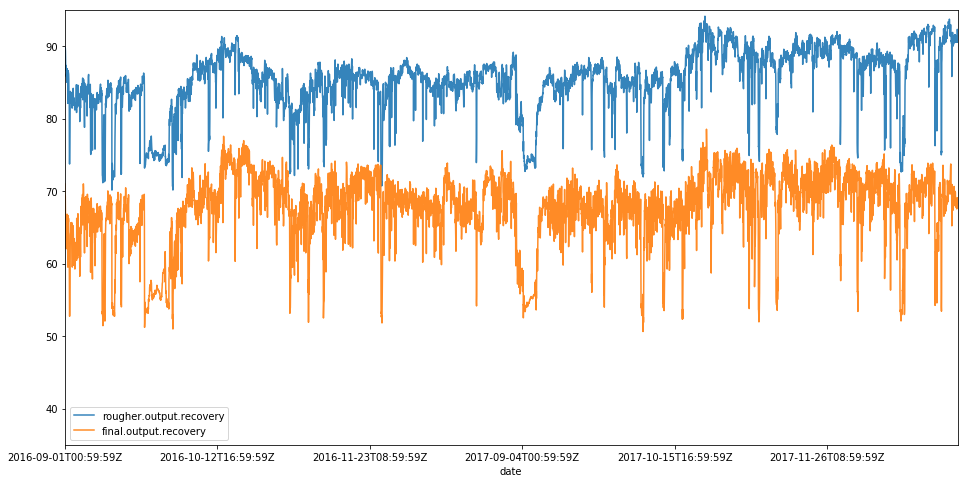

In [180]:
stacked_preds_sub.plot(style=['-','-'],figsize = (16,8),alpha=0.9,ylim = [35,95])


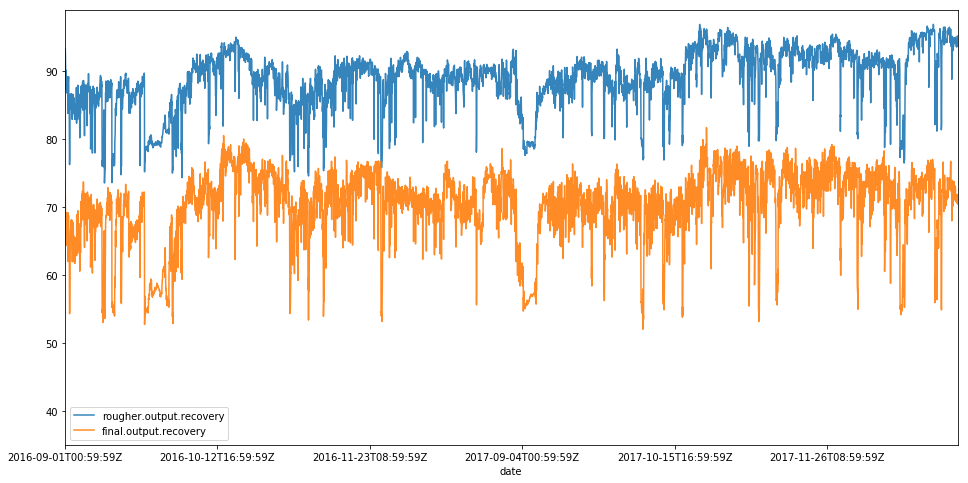

In [254]:
preds = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':level0_rougher_test.dot(w_rougher)*1.04, 'final.output.recovery':level0_final_test.dot(w_final)*1.04})
stacked_preds_sub = preds
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
#stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_r_250_f350_averaged_minmax_slope_interactions_proddiff_optimized_1_04.csv')
stacked_preds_sub.plot(style=['-','-'],figsize = (16,8),alpha=0.9,ylim = [35,99])


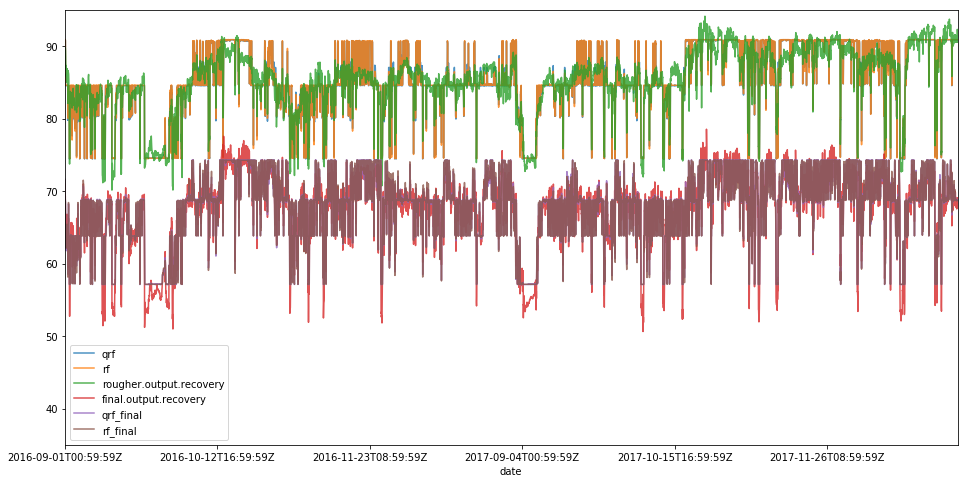

In [178]:
# for linear model
level0_rougher_test_lm[(level0_rougher_test_lm>98) | (level0_rougher_test_lm<30)] = np.median(level0_rougher_test_lm)
level0_final_test_lm[(level0_final_test_lm>80) | (level0_final_test_lm<30)] = np.median(level0_final_test_lm)
# ,'rougher.output.recovery':np.median(level0_rougher_test_lm,axis=1), 'final.output.recovery':np.median(level0_final_test_lm,axis=1)
preds = pd.DataFrame(data = {'date':X_test.index,'qrf':pred_qrf_rougher,'rf':pred_rf_rougher,'rougher.output.recovery':level0_rougher_test.mean(axis=1), 'final.output.recovery':level0_final_test.mean(axis=1),
                            'qrf_final':pred_qrf_final,'rf_final':pred_rf_final})
stacked_preds_sub = preds
stacked_preds_sub['date'] = stacked_preds_sub['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
stacked_preds_sub.set_index('date',inplace=True)
#stacked_preds_sub.drop_duplicates(inplace=True)
stacked_preds_sub.to_csv('../results/stacked_sub_lgb_lasso_base_alldata_averaged_minmax_slope_interactions_proddiff_linear.csv')
stacked_preds_sub.plot(style=['-','-'],figsize = (16,8),alpha=0.8,ylim = [35,95])


In [ ]:
r = np.power(level0_testFeatures_rougher.prod(axis=1),1/level0_testFeatures_rougher.shape[1])
f = np.power(level0_testFeatures_final.prod(axis=1),1/level0_testFeatures_final.shape[1])

preds_av = pd.DataFrame(data = {'date':X_test.index,'rougher.output.recovery':r, 'final.output.recovery':f})
preds_av['date'] = preds_av['date'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')
preds_av.set_index('date',inplace=True)
preds_av.plot(figsize = (20,10),style=['o','o'],alpha=0.9)